In [1]:
NAME = "" # put your full name here
COLLABORATORS = [] # list names of anyone you worked with on this homework.

# [ER 131] Homework 5: Modeling
<br>

## Table of Contents
1 - [Project](#section1)<br>
2 - [Set-Up](#section2)<br>
3 - [Single Linear Regression with scikit-learn](#section3)<br>
4 - [K-Nearest Neighbors](#section4)<br>

Reminder: Before you submit this assignment, remember to run all cells (e.g. with **Kernel** --> **Restart Kernel & Run All Cells...**). You won't recieve credit for cells you didn't run. 

---
Welcome to Homework 5! In this homework, you will create your first models to predict air quality data using the linear regression and K-nearest neighbors. But first, you'll spend some more time preparing your final project.

## Learning Objectives
By the end of this homework, you should be able to:
* Demonstrate the ability to work with new data and use new tools that help manage and summarize large data sets.
* Implement a simple linear regression in scikit-learn
* Explain how KNN works and make some cool maps in the process
* Analyze the spatial distribution of annual changes in pollutant concentrations

---


## Section 1: Project (5 pts) <a id='section1'></a>

In this section, you'll further develop your final project ideas.

**Question 1.1 (1 point)** In Homework 4 last week, you provided a few initial ideas for the final project. Refer back to that homework and to the project-related discussions and thinking you have engaged in over the past week. Now pick one project idea to develop further. Briefly describe the project idea you'll be developing for this assignment. 

*YOUR ANSWER HERE*

**Question 1.2 (1 point)** For the final project, you'll be building a prediction model of the form $\hat{y}_i = \hat{f}(x_i)$.  In the context of your final project idea, what is your target variable $y$?  In other words, what is the specific quantity you're trying to predict? Note, this can be binary (0, 1) to support categorical yes/no predictions. 

*YOUR ANSWER HERE*

**Question 1.3 (1 point)** What would $i$ index?  I.e., what constitutes an observation?  Is it a point in space, a moment in time, a firm, an individual...? 

*YOUR ANSWER HERE*

**Question 1.4 (1 point)** What are some candidate features to include in $x$?  

*YOUR ANSWER HERE*

**Question 1.5 (1 point)** Find (at least) two potential data sources you might use to explore your prediction questions. Insert a link to and a brief description of each dataset below. 

*YOUR ANSWER HERE*

---
## Section 2: Set-Up <a id='section2'></a>

**Dependencies:**

In [2]:
# # Run this cell to install these packages
# ! pip install sklearn
# ! pip install plotly
# ! pip install mapbox

In [3]:
# Run this cell to set up your notebook
import requests
from pathlib import Path
import zipfile
import os
import csv
import pandas as pd
import numpy as np
from numpy.linalg import inv

pd.set_option('display.max_columns', None)

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import geopandas as gpd

---
## Section 3: Simple Linear Regression with `scikit-learn` <a id='section3'></a>

We'll start by learning how to fit a simple linear regression in [`scikit-learn`](http://scikit-learn.org/stable/), a popular Python package for machine learning algorithms. The `scikit-learn` documentation is quite good, so feel free to browse if you would like to learn the details behind how their functions work.

For this section, we will use `scikit-learn` to build a simple prediction model of particulate concentration over time. 

### Downloading and Filtering the Data

First, let's download the data we will be using for this section. Run the following cell below to download the zip files from the EPA website. Each file contains a dataset of annual air pollutant concentrations by site, or "monitor", and related data. The documentation for these datasets is available [here](https://aqs.epa.gov/aqsweb/airdata/FileFormats.html).

In [7]:
# Download the zip files from the EPA website
# This cell only needs to be run once.
# Once the files are downloaded, they'll stay on datahub and you can skip this cell.
for year in np.arange(1998, 2024):
    airquality_url = 'https://aqs.epa.gov/aqsweb/airdata/annual_conc_by_monitor_' + str(year) + '.zip'
    airquality_path = Path('data/aqs/annual_conc_by_monitor_' + str(year) +'.zip')
    if not airquality_path.exists():
        print('Downloading ' + str(airquality_path) + ' ...', end=' ')
        airquality_data = requests.get(airquality_url)
        with airquality_path.open('wb') as f:
            f.write(airquality_data.content)
        print('Done!')

Let's try to get a sense of what our data look like. Run the next cell to see the 2021 dataset.

In [ ]:
airquality_path = Path('data/aqs/annual_conc_by_monitor_2021.zip')
zf = zipfile.ZipFile(airquality_path, 'r')
f_name = 'annual_conc_by_monitor_2021.csv'

# Unzip the file
with zf.open(f_name) as fh:
    # Create data frame
    annual_2021 = pd.read_csv(fh, low_memory=False)

annual_2021.head()

,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Sample Duration,Pollutant Standard,Metric Used,Method Name,Year,Units of Measure,Event Type,Observation Count,Observation Percent,Completeness Indicator,Valid Day Count,Required Day Count,Exceptional Data Count,Null Data Count,Primary Exceedance Count,Secondary Exceedance Count,Certification Indicator,Num Obs Below MDL,Arithmetic Mean,Arithmetic Standard Dev,1st Max Value,1st Max DateTime,2nd Max Value,2nd Max DateTime,3rd Max Value,3rd Max DateTime,4th Max Value,4th Max DateTime,1st Max Non Overlapping Value,1st NO Max DateTime,2nd Max Non Overlapping Value,2nd NO Max DateTime,99th Percentile,98th Percentile,95th Percentile,90th Percentile,75th Percentile,50th Percentile,10th Percentile,Local Site Name,Address,State Name,County Name,City Name,CBSA Name,Date of Last Change
0,1,3,10,44201,1,30.497478,-87.880258,NAD83,Ozone,1 HOUR,Ozone 1-hour 1979,Daily maxima of observed hourly values (betwee...,INSTRUMENTAL - ULTRA VIOLET ABSORPTION,2021,Parts per million,No Events,5573,99,Y,243,245,0,307,0.0,0.0,Certified,0,0.041786,0.010132,0.068,2021-07-27 15:00,0.067,2021-08-02 11:00,0.066,2021-07-28 15:00,0.063,2021-06-15 12:00,NaN,NaN,NaN,NaN,0.066,0.063,0.058,0.055,0.049,0.043,0.028,"FAIRHOPE, Alabama","FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...",Alabama,Baldwin,Fairhope,"Daphne-Fairhope-Foley, AL",2024-05-25
1,1,3,10,44201,1,30.497478,-87.880258,NAD83,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-Hour 1997,Daily maximum of 8 hour running average of obs...,NaN,2021,Parts per million,No Events,5817,98,Y,240,245,0,0,0.0,0.0,Certified,0,0.037963,0.009691,0.058,2021-07-28 09:00,0.057,2021-04-10 13:00,0.056,2021-06-17 09:00,0.056,2021-07-27 11:00,NaN,NaN,NaN,NaN,0.056,0.056,0.054,0.051,0.045,0.038,0.025,"FAIRHOPE, Alabama","FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...",Alabama,Baldwin,Fairhope,"Daphne-Fairhope-Foley, AL",2024-05-25
2,1,3,10,44201,1,30.497478,-87.880258,NAD83,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-Hour 2008,Daily maximum of 8 hour running average of obs...,NaN,2021,Parts per million,No Events,5817,98,Y,240,245,0,0,0.0,0.0,Certified,0,0.037963,0.009691,0.058,2021-07-28 09:00,0.057,2021-04-10 13:00,0.056,2021-06-17 09:00,0.056,2021-07-27 11:00,NaN,NaN,NaN,NaN,0.056,0.056,0.054,0.051,0.045,0.038,0.025,"FAIRHOPE, Alabama","FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...",Alabama,Baldwin,Fairhope,"Daphne-Fairhope-Foley, AL",2024-05-25
3,1,3,10,44201,1,30.497478,-87.880258,NAD83,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-hour 2015,Daily maximum of 8-hour running average,NaN,2021,Parts per million,No Events,4121,98,Y,241,245,0,0,0.0,0.0,Certified,0,0.037813,0.009764,0.058,2021-07-28 09:00,0.057,2021-04-10 13:00,0.056,2021-06-17 09:00,0.056,2021-07-27 11:00,NaN,NaN,NaN,NaN,0.056,0.056,0.053,0.051,0.045,0.038,0.024,"FAIRHOPE, Alabama","FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...",Alabama,Baldwin,Fairhope,"Daphne-Fairhope-Foley, AL",2024-05-25
4,1,3,10,88101,1,30.497478,-87.880258,NAD83,PM2.5 - Local Conditions,24 HOUR,PM25 24-hour 1997,Daily Mean,R & P Model 2025 PM-2.5 Sequential Air Sampler...,2021,Micrograms/cubic meter (LC),No Events,116,95,Y,116,122,0,6,0.0,0.0,Certified,0,7.268103,2.995173,15.400,2021-07-27 00:00,15.300,2021-11-09 00:00,14.600,2021-09-07 00:00,14.300,2021-03-08 00:00,NaN,NaN,NaN,NaN,15.300,14.600,14.000,11.600,8.800,6.500,4.300,"FAIRHOPE, Alabama","FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...",Alabama,Baldwin,Fairhope,"Daphne-Fairhope-Foley, AL",2024-05-17


For this homework, we will only be considering measures for PM2.5 in the state of California. Our goal right now is to create a single dataframe that compiles data from all of the annual files. To do this, you will create a loop that opens the csv file within each zip file, reads that .csv file into a dataframe, and creates a filtered dataframe that contains only the data we care about. Then, you can concatenate that dataframe to a dataframe called `ca_pm25` so that each time you run through the loop, you've added data from a different year to your dataframe. 

<br><b>Question 3.1 (3 pts):</b> Create one dataframe, `ca_pm25`, that contains PM 2.5 data for California only. We want records that use a '24 HOUR' sample duration and the 'PM25 Annual 2012' pollutant standard. Explicitly, we want to filter each annual dataset based on the following criteria:

- `Parameter Code` should be 88101 (PM 2.5 data)
- `State Name` should be 'California'
- `Sample Duration` should be '24 HOUR'
- `Pollutant Standard` should be 'PM25 Annual 2012'

When you concatenate, make sure the `axis` parameter is correctly specified so that each iteration adds **rows** associated for a given year to the dataframe. You may also set the `ignore_index` parameter to `TRUE`. If you're not sure where to start, look at the previous block to see how we open zipfiles and then access .csv files from within those zip files.

In [ ]:
# Replace the ellipses with your code

ca_pm25 = pd.DataFrame() # initialize empty dataframe

for year in np.arange(1998, 2024):
    
    # YOUR CODE HERE
    
    zip_path = ...
    zf = zipfile.ZipFile(zip_path, 'r')
    f_name = ...
    
    # Unzip the file
    with zf.open(f_name) as fh:
        print('Opening ' + 'pm25_' + str(year) +'.csv', end='\n')
        
        # Create data frame
        df = pd.read_csv(fh, low_memory=False)

        # Filter data frame according to specifications
        df = ...

        # Append to ca_pm25
        ca_pm25 = pd.concat(...)
        
print('Done!')

In [51]:
# check your output
assert ca_pm25.shape == (2660, 55)
assert ca_pm25['Parameter Code'].unique() == 88101

In [17]:
# # optionally, run this cell to preview the merged dataframe
# ca_pm25.head()

### Using `scikit-learn`

Now that our data is loaded, we can use `scikit-learn`. Refer to Lab 5 for the introduction and important notes on the `linear_regression` tools in `scikit-learn`.

<b>Question 3.2 (2 pts):</b> Using `scikit-learn`, let's fit a linear regression model for the city of Bakersfield, California. First, create a `pm25_bakers` dataframe that contains only data for Bakersfield. Then, generate a linear regression object called `lm_bakers`. Finally, fit a linear model that predicts "Arithmetic Mean" (the target variable, which represents the annual mean PM2.5 concentration) as a function of "Year" (the independent variable). Save fitted model to an object called `fit_bakers`.<br>

In [ ]:
# Replace ellipses with your code 

pm25_bakers = ...
X = ... # specify the column of pm25_bakers containing the independent variable.
y = ... # specify the column of pm25_bakers containing the target variable. 
lm_bakers = ...
fit_bakers = ...

Now that we've fitted the linear model `fit_bakers`, we can use it to predict the PM 2.5 concentrations for each year. Our linear model has a `.predict()` method, which takes in X and returns a list of predicted y values. We can then use `matplotlib` to compare the regression line with the observed data points. 

<b>Question 3.3 (2 pts):</b> Generate `y_prediction`. Then, plot the `pm25_bakers` observations as well as the regression line. Make sure to give the plot a title, label the axes, and choose a range for the xticks that makes sense. Feel free to make further adjustments to the plot aesthetics.

In [ ]:
# YOUR CODE HERE
# Replace the ellipses with your code

y_prediction = ...
plt.figure(figsize=(9, 6))
plt.scatter(..., color='black') # plot the observations as a scatter plot
plt.plot(..., color='blue', linewidth=3) # plot the predictions as a regression line
plt.title('Mean Annual 24-hr PM2.5 Concentration in Bakersfield', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('LC', fontsize=13)
plt.xticks(np.arange(pm25_bakers['Year'].min(), pm25_bakers['Year'].max()+1, 2))
plt.show()

Let's do further analysis on the outputs. Namely, let's look at two coefficients that our linear regression object stores &mdash; $\hat{\beta}_0$ (the intercept) and $\hat{\beta}_1$ (the slope).

<b>Question 3.4 (1 pt):</b> Get the intercept and slope attributes of `fit_bakers`, then print them. You may want to browse through Lab 5 or the [`scikit-learn` documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) to figure out how to do this. 

In [ ]:
# YOUR CODE HERE
# Replace the ellipses with your code

intercept =  ...
slope = ...
print('Intercept:', intercept)
print('Slope:', slope)

<b>Question 3.5 (1pt):</b> Try to make sense of our intercept and slope. What do they mean? Write down an explanation.

*YOUR ANSWER HERE*

**Question 3.6 (1 pt):** What does our model predict the average PM 2.5 concentration in Bakersfield will be in 2030? How about 2050 and 2100? 

In [ ]:
# YOUR CODE HERE
predicted_2030 = ...
predicted_2050 = ...
predicted_2100 = ...
print('Prediction for 2030:', predicted_2030, 'LC')
print('Prediction for 2050:', predicted_2050, 'LC')
print('Prediction for 2100:', predicted_2100, 'LC')

**Question 3.7 (1 pt):** What assumptions are we making when we use the model to predict future concentrations? Are these assumptions realistic? 

*YOUR ANSWER HERE*

### Comparing Counties
---

We may also be interested in the trends in ambient air quality across each of the counties in our dataset. In this section, we'll use the basic modeling procedure illustrated above to fit a model for each county, then plot the estimated rates of change. 

**Question 3.8 (2 pts):** Using the code below as a starting point (or taking a different approach if you prefer), make a new dataframe called `county_pm`, which contains the estimated rate of change for each county. The final dataframe should have a `County` column, which contains the name of each county, and a `Slope` column, which contains the estimated regression coefficient for each county (as a float). 

In [ ]:
slopes = []
counties = ca_pm25['County Name'].unique()

# YOUR CODE HERE
for c in counties:
    # estimate a linear model for each county
    # then append the estimated slope to `slopes`
    ...

# YOUR CODE HERE
# construct the county_pm dataframe
county_pm = ...

In [78]:
assert (county_pm.columns == ['County', 'Slope']).all()
assert isinstance(county_pm.County[0], str)
assert isinstance(county_pm.Slope[0], float)
assert county_pm.shape == (45, 2)

**Question 3.9 (1 pt):** Out of the 45 counties in our air quality dataset, how many had increasing PM2.5 concentration trends over the sample period? Which counties were they? Return a list or pandas series of the relevant county names. 

In [ ]:
# YOUR CODE HERE
...

**Question 3.9 (1 pts):** Next, we want to map the estimated coefficients. To do this, we need to read the california counties shapefile and merge it with the dataframe of county-level coefficients that we just created. Perform this merge in the cell below. 

In [ ]:
import geopandas as gpd
county_shp = gpd.read_file('data/CA_Counties')
counties_merged = ... # YOUR CODE HERE

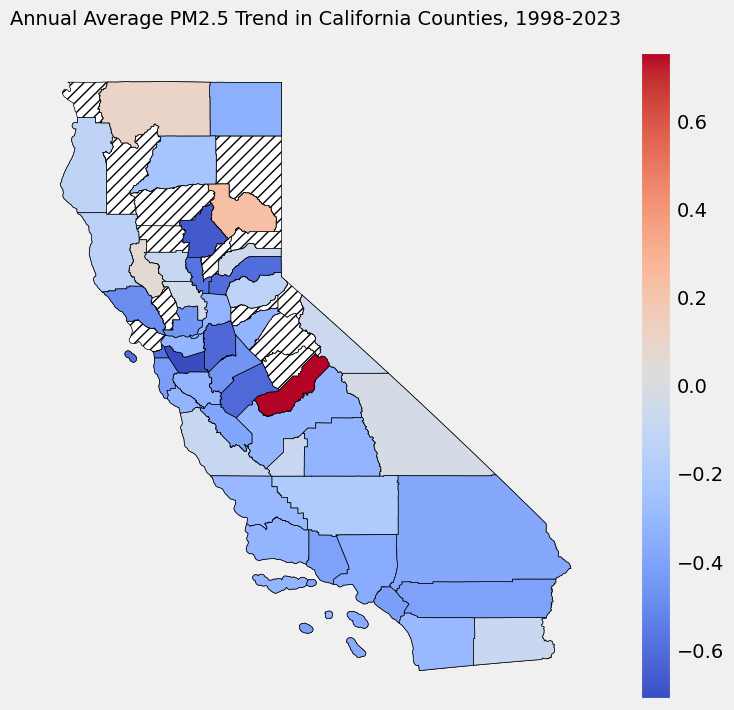

In [130]:
# run this cell to produce a map
fig, ax = plt.subplots(figsize=(10, 8))
counties_merged.plot(ax=ax, facecolor="white", edgecolor="black", hatch="///", linewidth=0.5, label='missing')
counties_merged.plot(ax=ax, column='Slope', cmap='coolwarm', legend=True, edgecolor='black')
ax.set_title("Annual Average PM2.5 Trend in California Counties, 1998-2023", fontsize=14)
ax.set_axis_off()

**Question 3.10 (1 pts):** We didn't look carefully at all of the county-level data before making the plot above. Is it possible that issues with the data could lead to a misleading plot? What is one such issue that you would check for if you were doing a more detailed analysis?

*YOUR ANSWER HERE*

---

## Section 4: K-Nearest Neighbors (OPTIONAL) <a id='section4'></a>


K-nearest neighbors is covered in Introduction to Statistical Learning. KNN for classification is described in Section 2.2.3 and for regression in Section 3.5. In this homework we're going to use KNN for quantiative spatial forecasting, meaning we'll predict a numeric value for a location in space based on the average of the K-nearest points in space for which we have data.

We'll use the EPA air pollution measurements again and create a map of predicted PM2.5 concentrations in locations throughout California. Let's run a KNN algorithm on the [hourly EPA PM2.5 data](https://aqs.epa.gov/aqsweb/airdata/FileFormats.html#_hourly_data_files) that we used in Homework 2. This time, we've gone ahead and created a reduced dataset that contains only the hourly data from California on August 28, 2021, the day with the worst average PM 2.5 concentrations of the year in both the Bay Area and the state overall. 

Take your time reading and working through this section; there are a lot of steps to calculating the K-nearest neighbours, but you'll get to produce a really cool plot at the end!<br>

In [ ]:
# Run the following cell
aug28 = pd.read_csv('data/pm25_aug28.csv')
aug28.head()

In addition, we've also gathered a dataset containing the latitude and longitude coordinates of every major city and town in the state of California as `ca_cities_towns.csv`. We will use these as the locations for which we will predict PM2.5 concentrations, based on the observations recorded in the `aug28` dataframe.

In [ ]:
# Run the following cell
ca_locations = pd.read_csv('data/ca_cities_towns.csv', low_memory=False)
ca_locations.head()

For our purposes, nearest neighbor proximity will be based on spatial distance. For a given location in `ca_locations`, we will find the *K* geographically nearest neighbors in the EPA dataset. Then, we will use average PM2.5 concentration at these neighbor points as the predicted concentration for our location of interest. This simple but effective algorithm will allow us to create a map of California on which we can color locations based on their observed and predicted PM2.5 concentrations.<br>

Before we jump into writing the KNN algorithm, here's a quick review of what KNN is (the lecture slides and Section 2.2 of ISLR are also helpful resources here). KNN estimates the value at a point by taking an average of the K nearest values to that point (so if K = 2, then the algorithm estimates the value at the point by taking the average value of the 2 nearest points). Mathematically, this looks like:

$$\hat{y}_j=\frac{1}{K}\sum_{i \epsilon N_j}y_i$$

In the formula above, we're trying to predict the value of $y$ at position *j*. $N_j$ is the set of $K$ points closest to *j*. The formula sums the $y$ values at all of the points within the set $N_j$, and then divides by $K$ to get an average.



### Writing the KNN Algorithm

Here we provide several functions that will be useful for manipulating our data: 

#### *Get hourly data*
Our KNN algorithm will estimate the PM2.5 concentration at each location during **a given hour.** This means that for each call to our algorithm, we will need to filter the EPA dataset and select only the observations that correspond to a given hour. 

Here we define the function `get_hour_data()`, which takes an hour parameter passed in as a string, and: 
- Returns a dataframe containing only data from `aug28` that was recorded during that hour
- Adds a new column to the filtered dataframe. The name of the new column should be 'Source,' and it should be populated with the string value 'Observation' for every row of the dataframe. 
- Renames the 'Sample Measurement' column to 'Value' (useful later on when we merge observed data from `aug28` with predicted data for `ca_locations`).


In [ ]:
# run this cell, do not change it
def get_hour_data(hour):
    '''
    Takes in a string `hour` indicating the hour (using a 24-hour clock) and returns the aug28 dataframe filtered
    to include only observations from that hour on August 28, 2021. Adds a "Source" column and assigns "Observation" 
    as its value for all observations. Renames the "Sample Measurement" column "Value."
    '''
    
    # Filter the aug28 dataframe to include only the observations recorded during `hour`
    hour_data = aug28.loc[aug28['Time Local'] == hour] 

    # Add a "Source" column to the filtered dataframe. Populate the column with the string "Observation".
    hour_data['Source'] = np.repeat('Observation', len(hour_data)) # Note: (np.repeat('a', 3)` returns `['a', 'a', 'a']`.)
    
    # Rename the "Sample Measurement" column "Value".
    hour_data.rename(columns={'Sample Measurement':'Value'}, inplace=True)
    
    return hour_data

In [ ]:
# run this cell, do not change it
assert get_hour_data('18:00').shape == (98, 25)
assert get_hour_data('23:00').shape[1] == aug28.shape[1] + 1

#### *Sample CA locations*

A downside to KNN is that it can be slow. If we are working with a large dataset, we will have to iterate many times over to find the K-nearest neighbors and thus our computational cost will be very high. `ca_locations` contains 1500+ cities and towns, so we will need to decrease its size to 150-300 locales to run the KNN algorithm efficiently.


**Question 4.1:** Write a `get_sample()` function that when called returns a dataframe with a random sample of $N$ locations from `ca_locations`. Along with $N$, this function should take as input a random seed parameter passed in as an integer. The random seed allows us to replicate the random set of locations everytime we run the function. Like `get_hour_data()`, `get_sample()` should return a dataframe with all of the original columns plus a new column, 'Source', that contains a string value 'Prediction' for every row. In addition, rename the "Location" column to "Locale". Again, these last two steps will be useful when we merge dataframes.


*Hint*: There are many ways to select random samples: you can use the numpy method that we used in lab and lecture, or [`pandas.sample()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html)

In [ ]:
def get_sample(N, seed):
    '''
    Inputs: ...
    Outputs: ...
    Objective: 
    '''
    
    # YOUR CODE HERE
    # Step 1: Randomly sample N rows from the ca_locations dataframe; set the random seed.
    ca_sample = ca_locations.sample(...)
    
    # Step 2: Add a "Source" column to the filtered dataframe of sampled locations. 
    # Populate the column with the string "Prediction".
    ca_sample['Source'] = np.repeat(...)
    
    # Step 3: Rename the "Location" column "Locale". Don't forget to use `inplace`.
    ca_sample.rename(...)
    
    return ...

In [ ]:
# run this cell
get_sample(200,1).head()

In [ ]:
assert get_sample(200,1).shape == (200,4)

#### *Calculate distances between measurement and prediction locations*

Now that we have functions to get our hour data and our sampled California cities and towns, it's time to set up the KNN algorithm. 

The first step to running KNN is to find the distance between the locations for which we want to make predictions (i.e., each of the randomly-sampled California locales) and the locations at which PM2.5 has been measured. Both the `aug28` and the `ca_locations` contain latitude and longitude coordinates. Let's take advantage of this and define a function that finds the distance between any two points given each point's latitude and longitude values. We can use the [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) formula; i.e., if we have one set of points $(a_1,b_1)$, and another set of points $(a_2,b_2)$, the distance between them is:<br>

$distance = \sqrt{(a_1-a_2)^2 + (b_1-b_2)^2}$

*Side note*: calculating distances between latitude-longitude pairs is often more complicated than the formula above makes it appear because the distance between two points of longitude actually varies based on how far away the points are from the equator. Since we're calculating distances over a relatively small area (the state of California), we can use the approximation above. If you wanted to accurately look at distances between latitude-longitude pairs over a larger area of the globe, you would have to use a slightly more involved trigonometry formula (and may depend on the projection in which you are working).

In [ ]:
def find_distance(x, y, a, b):  
    '''
    Returns a one-dimensional array containing the distances between a point whose coordinates are (`a`,`b`) 
    and a list of points whose x-coordinates are represented as the one-dimensional array `x`, and whose 
    y-coordinates are represented by the one-dimensional array `y`.
    '''
    return np.sqrt((np.subtract(x,a))**2 + np.subtract(y,b)**2)

**Question 4.2** Write a test case to check that `find_distance()` does what you expect it to do. Implement `find_distance()` to calculate how far the points [3,4] and [0,5] each are from the point [0,0]. Write two asserts: one assert to check that the function returns a numpy array, and another assert to check that the output of the function is one-dimensional and contains the number of elements you expect. 

In [ ]:
test_distance = find_distance(...)
print(test_distance)

assert ...
assert ...

Next, we'll use `find_distance()` to create a distance matrix. Each row will be one of the $N$ sampled California locations where we're interested in predicting the PM2.5 concentration. Each column will represent one of the locations from the EPA dataset at which PM2.5 has been measured. The elements of the array will represent the distance between each sampled California locale and each PM2.5 measurement during a given hour. 

The function, `get_dist_array()` creates this distance matrix. As input, it takes in `hour_data` - a dataframe of PM2.5 measurements during a given hour (i.e., the output of `get_hour_data()`) - and `ca_sample` - a dataframe of randomly-sampled locales in California (i.e., the output of `get_sample()`). It returns a numpy array with $N$ rows (for each California locale in the sample) and *M* columns, where *M* is equal to the number of rows in `hour_data` (i.e. the number of observed measurements in that hour).

In [ ]:
def get_dist_array(ca_sample, hour_data):
    '''
    Inputs: 
        hour_data - a dataframe of PM 2.5 observations at a given hour (i.e., the output of get_hour_data()). 
        ca_sample - a dataframe of sampled cities and towns in California (i.e., the output of get_sample()). 
    Outputs: a numpy array with N rows (for each California location in the sample) and M columns, 
        where M is equal to the number of rows in `hour_data` (i.e. the number of observed measurements in that hour).
    '''
    
    dist_array = np.full((len(ca_sample), len(hour_data)), np.nan) # initialize an array of size NxM, filled with NaN 
    
    for i in range(len(ca_sample)): # loop through CA cities/towns
        # calculate distance between each city/town and each measurement location, and add to array row
        dist_array_i = find_distance(hour_data['Latitude'],hour_data['Longitude'],
                                        ca_sample.iloc[i]['Latitude'], ca_sample.iloc[i]['Longitude']) 
        dist_array[i,:] = dist_array_i
    
    return dist_array


In [ ]:
# run this cell
hour_data = get_hour_data('18:00')
ca_sample = get_sample(200,1)
test_array = get_dist_array(ca_sample, hour_data)
print(test_array)
assert test_array.shape == (200,98)

**Question 4.3:** If Pacific Grove was the first out of the cities to appear in the output of `get_sample()`, and if the first row in the output from `get_hour_data()` was in Alameda county, then how would you interpret: 
- the values in row 0 of the distance matrix?
- the values in column 0 of the distance matrix?

*YOUR ANSWER HERE*

#### *Predict PM 2.5*

**Question 4.4:** Next, we have provided you with a function that predicts PM2.5 concentrations for each point in your set of randomly-sampled California locales based on the mean PM2.5 measurement of its K-nearest measurement locations. This function, `predict_PM25()`, takes in as parameters the `hour_data` dataframe, the `ca_sample` dataframe, and a value for $K$.

Instead of having you write the function, we just want to make sure that you understand what the function is doing. Fill in the function description in red at the top of the function, and then complete the in-line documentation for every hash (#) followed by elipses below. 

In [ ]:
def predict_PM25(hour_data, ca_sample, K):
    '''
    Inputs: 
    Outputs: 
    Objective: 
    '''
        
    # ...
    predicted_measurements = [] 
    
    # ...
    dist_array = get_dist_array(ca_sample, hour_data) 
    
    # for every value in ...
    for i in range(dist_array.shape[0]): 
        dist_i = dist_array[i,:] # ...
        hour_k = hour_data["Value"].iloc[np.argsort(dist_i)] # ...
        knn = hour_k[0:K] # ...
        predicted_measurements.append((1/K)*np.sum(knn)) # ...
    
    ca_sample['Value'] = predicted_measurements # ...
    return ca_sample

In [ ]:
# run this cell
hour_data = get_hour_data('18:00')
ca_sample = get_sample(200,1)
test = predict_PM25(hour_data, ca_sample, 2)
assert test.shape == (200,5)
assert test.loc[test['Locale']=="North Shore",'Value'].values==8.35
test.head() # your ca_sample dataframe should have 5 columns: Locale, Latitude, Longitude, Source, and Value

#### *Preparing the data for mapping*

Data that we work with is often messy, incomplete, and/or missing important values. Case in point: the hourly dataset we pulled from the EPA website that we have been working with so far &mdash; although it contains precise latitude and longitude coordinates for each location &mdash; only contains the county name for each location and not the city or town. This is in contrast to `ca_locations` which contains city and town names.

We might like to have the city and town names visible instead of county names for greater accuracy and clarity. Happily, we can use `ca_locations` and the other functions we've written thus far to approximate the locations in the `hour_data` based on their latitude and longitude coordinates.

The function `approximate_locale()` takes as input `hour_data` and `ca_locations`. For every record in the `hour_data`, the function goes through all the records in `ca_locations` and finds the nearest city or town to that measurement. The function returns the `hour_data` dataframe with a new, appended 'Locale' column that contains the name of the closest city or town. 

In [ ]:
def approximate_locale(hour_data, ca_locations):
    '''
    Takes in as parameters the hour_data dataframe and the ca_sample dataframe. 
    Returns the `hour_data` dataframe with a new 'Locale' column. Each element is the name (as a string) 
    of the nearest city or town to the measurement site.
    '''
    nearest_locale = []
    
    dist_array = get_dist_array(ca_locations, hour_data) # get matrix of distances between sampled cities/towns and measurement locations
    
    for j in range(dist_array.shape[1]): # loop through all measurement locations (columns)
        dist_j = dist_array[:,j] # select the column of dist_matrix that contains the distances from the jth measurement location to all cities/towns
        measurement_locale = ca_locations['Location'].iloc[np.argsort(dist_j)].iloc[0] # sort location names by distance and grab the nearest one
        nearest_locale.append(measurement_locale) # append the name of the nearest city or town to nearest_locale. 
    
    hour_data['Locale'] = nearest_locale # create a new column called "Locale" in hour_data to hold the names of the nearest cities/towns
    return hour_data

For a quick check of the results, you can choose a couple lat-long coordinates in `hour_data`, input them to Google Maps, and make sure that the 'Locale' that your code is outputting is at or near those coordinates.

In [ ]:
# run this cell; do not change it
hour_data = get_hour_data('18:00')
ca_sample = get_sample(200,1)
approximate_locale(hour_data, ca_locations).head()

We're almost there! To make a meaningful plot, we need to do a little more formatting. Taking a glance at `aug28`, we see that our PM2.5 sample measurements range anywhere from about 0 LC to more than 600 LC, with the vast majority of data falling far below 200 LC.

In [ ]:
# run this cell to see the distribution of measurements
plt.hist(aug28["Sample Measurement"]);
plt.title("Distribution of PM2.5 observations on Aug. 28, 2021")
plt.xlabel("PM2.5 concentration")
plt.ylabel("Count")
plt.show()

To allow our plot of PM2.5 concentrations to have greater color contrast, we will need to take the log of these values.

The functions `convert_to_log()` takes in a dataframe `df`, with a column "Value" that contains either the observed or predicted PM25 concentration, a column "Locale" that contains the nearest town or city name, and a column "Source" that contains the data source ("Observation" or "Prediction").

`convert_to_log()` returns the dataframe with a new, appended 'Log Value' column, whose elements are the natural logarithms of the "Value" column in the same dataframe.

In [ ]:
def convert_to_log(df):
    '''
    Input: df - dataframe
    Output: Returns the input dataframe df with a new column "Log Value" whose elements are the natural logarithms of the values 
    in the Value column
    Objective: Find the log value of our PM2.5 concentrations
    '''
    
    df['Log Value'] = np.log(df['Value'])
    return df

In [ ]:
# Run this cell to test your new functions
hour_data = get_hour_data('18:00')
ca_sample = get_sample(200,1)
test = predict_PM25(hour_data, ca_sample, 2)
formatting_test = convert_to_log(test)
assert formatting_test.shape[1] == 6
formatting_test.head()

#### *Run the KNN algorithm and map the data*

We are finally ready to put together all the functions we've created so far to run the KNN algorithm and map the data.

<br>

<b>Question 4.5:</b> Write the `knn_algorithm()` function. The input parameters are:
- hour: the hour (as a string) on which to filter the data
- N_locales: an integer number of cities or towns to sample from `ca_locations`
- seed: an integer for the random seed to use to choose the sample of locales
- K: an integer designating the number of nearest neighbors on which to base the algorithm.

Your function should merge the predicted and observed PM2.5 concentrations for the designated hour into one dataframe (*hint:* use an outer merge on more than one column). 

If you are stuck or unsure how to approach this problem, try looking back to see the order of the steps we took to get the data, run the algorithm, and format the data for plotting. If you later encounter any errors, try going back to your previous code to look for any potential mistakes.

In [ ]:
def knn_algorithm(hour, N_locales, seed, K):
    
    hr_data = get_hour_data(...)
    ca_samp = get_sample(...)
    predicted_pm25 = predict_PM25(...)
    measurement_locales = approximate_locale(...)
    merged_df = predicted_pm25.merge(...)
    merged_df = convert_to_log(...)
    observed_data = merged_df.loc[...]
    predicted_data = merged_df.loc[...]
    
    return observed_data, predicted_data, merged_df, hour, K

### Analyzing the KNN Algorithm

**Question 4.6:** Try out the KNN algorithm for `hour='12:00'`, `N_locales=250`, `seed=2023`, and `K=5`. Then run the cells below your answer to plot the data and get a strong grasp of what the data looks like in both a local and a regional sense. Once you've done that, try it out for different hours and for different values of K.

The K value should be the main focus of your analysis. Try different values of K to see the changes in predicted measurements. And keep in mind that larger values of K will take longer to load &mdash; most likely anything more than K = 10 might take too long to run.

Also, try out different seeds, but keep in mind that the seed is meant to preserve a randomized set of locations, so when comparing different hours and K values it is best to keep the same seed.

In [ ]:
obs, pred, merged, hour, K = knn_algorithm(...)

In [ ]:
# Run this cell to convert to GeoDataFrame and import counties maps
obs_gdf = gpd.GeoDataFrame(obs, geometry=gpd.points_from_xy(obs.Longitude, obs.Latitude), crs = 'EPSG: 4326')
pred_gdf = gpd.GeoDataFrame(pred, geometry=gpd.points_from_xy(pred.Longitude, pred.Latitude), crs = 'EPSG: 4326')

# You may have to uncomment and run this line:
# !pip install pyogrio
counties = gpd.read_file('CA_Counties/CA_Counties_TIGER2016.shp', engine = 'pyogrio')
counties.drop('STATEFP',axis=1,inplace=True)
counties.to_crs(epsg=4326, inplace=True)

In [ ]:
# plot the data

fig, ax = plt.subplots(figsize=(8,12))

pred_gdf.plot(ax=ax, column='Log Value', cmap='plasma', legend_kwds={'label': "Value"}, marker='o', label='Predicted')
obs_gdf.plot(ax=ax, column='Log Value', cmap='plasma', legend = True, legend_kwds={'label': "Value"}, marker='s', label='Observed', edgecolor='black', alpha = 0.5, )
counties.plot(ax=ax, color = 'white', edgecolor='gray', alpha = 0.3)
ax.legend()
ax.axis('off') # You can optionally omit the axes

# Show a title
ax.set_title('PM2.5 Concentrations')

plt.show()

<b>Question 4.7:</b> Comment on what you think is a "good" value of K, and explain why. Note that there is no single right answer here, but there are undoubtedly better and worse options &mdash; what would be a bad value of K?

*Your answer here*

<b>Question 4.8:</b> What are other factors that might be affecting spatial distributions? Explain why it would be good to create a model that predicts concentrations based on location, nearby measurements *and* the other factors that you've listed.

*Your answer here*

----
## Submission

Congrats, you've finished homework 5! Before you submit, click **Kernel** --> **Restart Kernel & Run All Cells...**. Then, go to the toolbar and click **File** -> **Save and Export Notebook As** -> **HTML** and submit the file through bCourses.


----

## Bibliography

- Adi Bronshtein - Referred to KNN concepts. https://medium.com/@adi.bronshtein/a-quick-introduction-to-k-nearest-neighbors-algorithm-62214cea29c7

- Anwar A. Ruff - Used normal equation example as model. https://github.com/aaruff/Course-MachineLearning-AndrewNg/blob/master/NormalEquation.ipynb

- Introduction to Statistical Learning - Referred to KNN concepts. https://www-bcf.usc.edu/~gareth/ISL/

- Manu Jeevan - Adapted scikit-learn techniques. http://bigdata-madesimple.com/how-to-run-linear-regression-in-python-scikit-learn/

- Maps of World - Obtained latitude/longitude of CA cities and towns. https://www.mapsofworld.com/usa/states/california/lat-long.html

- scikit-learn.org - Referred to scikit-learn documentation. http://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html

- Shawon Ashraf - Adapted normal equation implementation techniques. https://www.c-sharpcorner.com/article/normal-equation-implementation-from-scratch-in-python/

---
Notebook developed by: Joshua Asuncion, edited by Dawson Verley

Data Science Modules: http://data.berkeley.edu/education/modules
